<h1><center>IST 597 Foundations of Deep Learning</center></h1>

---

<h2><center>Convolution Neural Networks</center><h2>
<h3><center>Neisarg Dave</center><h3>

### Convolution and Cross Correlation
+ **Convolution**
  $$
  (f \star g)(t) =  \int_{-\infty}^{\infty} f(\tau)g(t-\tau)d\tau
  $$
+ **Cross-Correlation**
  $$
  (f \star g)(t) =  \int_{-\infty}^{\infty} f(\tau)g(\tau+t)d\tau
  $$

In CNNs, the kernel function $g$ is composed of learnable parameters. Hence we do not need to flip the kernel. Essentially we are computing cross-correlations at each layer

**Conv Layers in Pytorch**
+ https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

**A guide to Convolution Arithmetic**
+ https://arxiv.org/pdf/1603.07285.pdf

### Stride and Padding

**CNN Explainer**
+ https://poloclub.github.io/cnn-explainer/

**Animations by Animated AI**
+ https://www.youtube.com/playlist?list=PLZDCDMGmelH-pHt-Ij0nImVrOmj8DYKbB
+ https://animatedai.github.io



### Max Pooling
![](https://deeplizard.com/assets/jpg/695a6a24.jpg)
Image Credits : https://deeplizard.com/learn/video/ZjM_XQa5s6s


### Field of View (Receptive Field)
+ Lets define a CNN with 3 convolution layers. Each layer has a kernel size of 3x3 and a stride of 1.
+ In layer 1, each pixel in feature space is a function of 3 pixels in x axis and 3 pixels in the y axis of input image. Hence the field of view here is 3x3.
+ In layer 2, each pixel in featue space has a field of view of 3x3 in the feature space of layer 1. And by extension the field of view of these 3x3 pixels in input space will be of 5x5.
+ Thus, the field of view of a pixel in feature space at depth $d$, can be given by:
$$[3 + 2*(d-1)] \times [3 + 2*(d-1)]$$

![](https://theaisummer.com/static/490be17ee7f19b78003c3fdf5a6bbafc/83b75/receptive-field-in-convolutional-networks.png)

Image Credits : https://theaisummer.com/receptive-field/

**TODO** 
+ Derive the general formula for field of view for kernel size $k$ and stride $s$
+ What happens to field of view at pooling layer?

### Transposed Convolutions
+ https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
+ https://www.matthewzeiler.com/mattzeiler/deconvolutionalnetworks.pdf


### Batch Normalization


Let there be $m$ samples in a batch $B$. The mean and variance of the feature maps can be defined as:
$$
  \mu_B = \frac{1}{m}\sum_{i=0}^{m} x_i
$$
$$
  \sigma_B^2 = \frac{1}{m}\sum_{i=0}^{m} (x_i - \mu_B)^2 
$$

+ Normalizing the features :
$$
  \hat x_i = \frac{x_i - \mu_b}{\sqrt{\sigma_B^2 + \epsilon}}
$$

+ Scale and shift:
$$
y_i = \gamma x_i + \beta
$$

+ $\gamma$ and $\beta$ are learnable parameters

In [1]:
import torch
import random
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import clear_output
import numpy as np
import pprint
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn 
%matplotlib inline


In [2]:
device = torch.device("cuda:0")

seed = 1234 
random.seed(seed)
torch.manual_seed(seed)

In [3]:
train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

val_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [10000, 40000])

print(len(train_dataset), len(val_dataset), len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
40000 10000 10000


In [4]:
class_to_idx = {
    "airplane"    : 0,
    "automobile"  : 1,
    "bird"        : 2,
    "cat"         : 3,
    "deer"        : 4,
    "dog"         : 5,
    "frog"        : 6,
    "horse"       : 7,
    "ship"        : 8,
    "truck"       : 9
}
idx_to_class = {i:c for c, i in class_to_idx.items()}

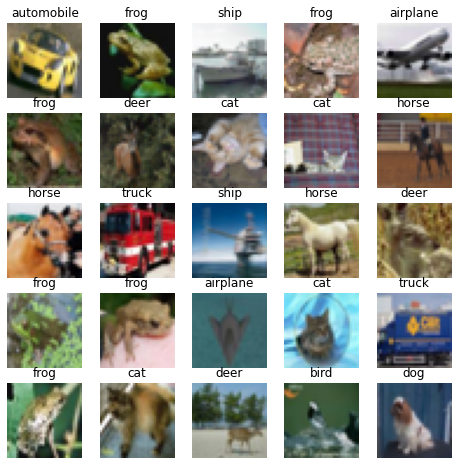

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    label = idx_to_class[label]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze())
plt.show()

In [6]:
class ConvolutionNeuralNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvolutionNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=2, padding=0)
        self.norm1 = nn.BatchNorm2d(96)
        self.nonlin1 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.norm2 = nn.BatchNorm2d(256)
        self.nonlin2 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2304, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes))
        
    def forward(self, x):
        raw_features = []
        normed_features = []

        out = self.conv1(x)
        raw_features.append(out.detach().cpu())
        out = self.norm1(out)
        normed_features.append(out.detach().cpu())
        out = self.nonlin1(out)

        out = self.conv2(out)
        raw_features.append(out.detach().cpu())
        out = self.norm2(out)
        normed_features.append(out.detach().cpu())
        out = self.nonlin2(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out, raw_features, normed_features
    

In [7]:
matplotlib.rcParams.update({'font.size': 22})
def plot_live(steps, x_lim, loss_list, img, raw_f, normed_f):
  clear_output(wait=True)
  fig = plt.figure(figsize=(24, 12))
  ax1 = fig.add_subplot(1, 2, 1)
  
  ax1.set_xlim(0, x_lim)
  ax1.set_ylim(0, 3)
  x = steps
  y = loss_list  
  if len(x) > 1:
      ax1.scatter(x,y, label='axis y', color='k') 
      m, b = np.polyfit(x, y, 1)
      plt.plot(x, [x * m for x in x] + b)

  ax1.set_title("Loss Curve")
  ax1.grid(True)
  ax1.set_xlabel('# Iterations')
  ax1.set_ylabel('Loss')
  
  ax2 = fig.add_subplot(1, 2, 2)
  ax2.hist(img.view([-1]).numpy(), bins = 100, histtype="step", label="input", density=True)
  #print(img.shape)
  for ii, feature in enumerate(raw_f):
    #print(torch.min(feature), torch.max(feature))
    #print(feature.view([-1]).shape)
    ax2.hist(feature.view([-1]).numpy(), bins = 100, histtype = "step", label = "layer {} raw".format(ii+1), density=True)


  for ii, feature in enumerate(normed_f):
    #print(torch.min(feature), torch.max(feature))
    #print(feature.view([-1]).shape)
    ax2.hist(feature.view([-1]).numpy(), bins = 100, histtype = "step", label = "layer {} normed".format(ii+1), density=True)
  ax2.set_title("Feature Distributions")
  ax2.legend()
  
  plt.show()


In [8]:
batch_size = 1024
train_data = DataLoader(train_dataset, batch_size = batch_size)
test_data = DataLoader(test_dataset, batch_size = batch_size)
val_data = DataLoader(val_dataset, batch_size = batch_size)

loss_fn = torch.nn.CrossEntropyLoss()
model = ConvolutionNeuralNetwork().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0, momentum = 0.9)

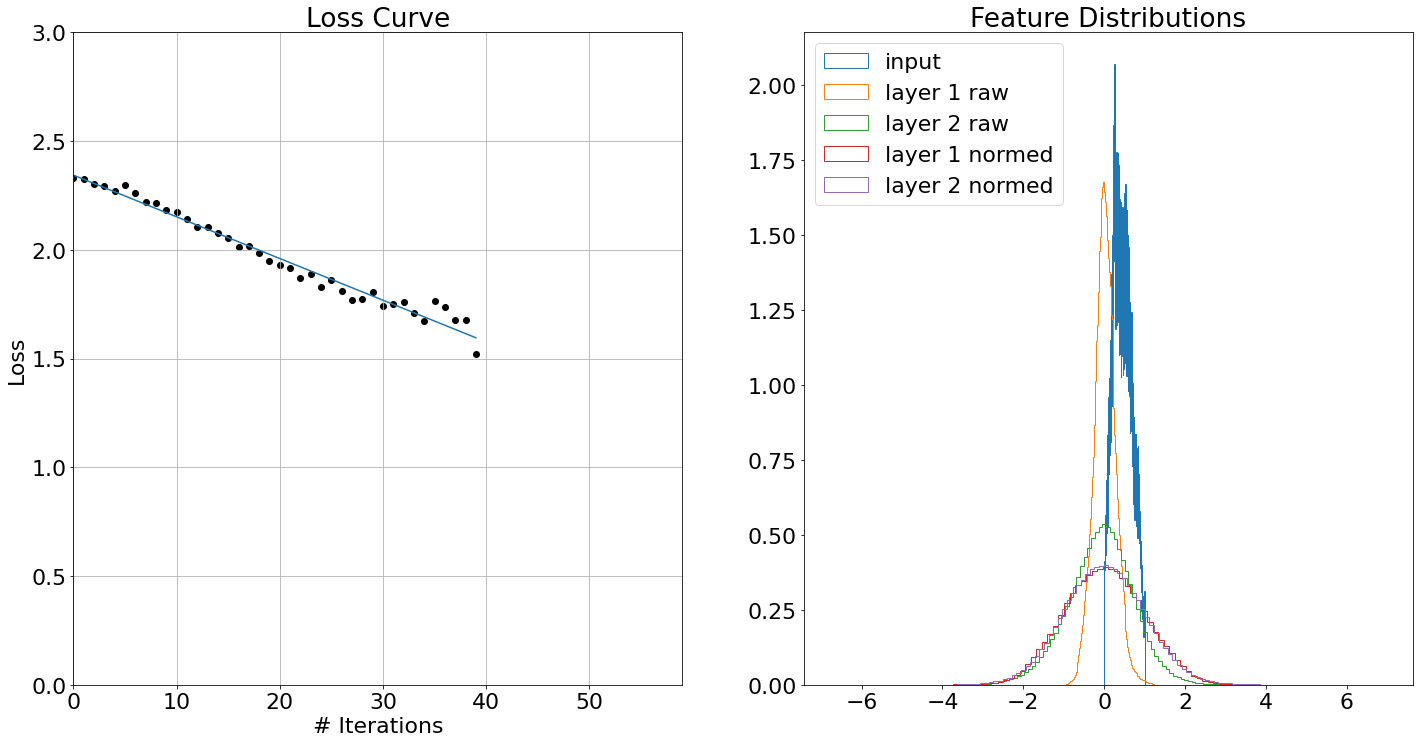

In [9]:
steps = []
loss_list = []
for epoch in range(1):
  for i, batch_data in enumerate(train_data):
    img, label = batch_data
    #print(img.shape)
    logits, raw_f, normed_f = model(img.cuda())
    loss = loss_fn(logits, label.cuda())
    steps.append(epoch*50+i)
    loss_list.append(loss.detach().cpu().item())
    #print(i, loss)
    plot_live(steps, epoch*50+i+20, loss_list, img, raw_f, normed_f)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()